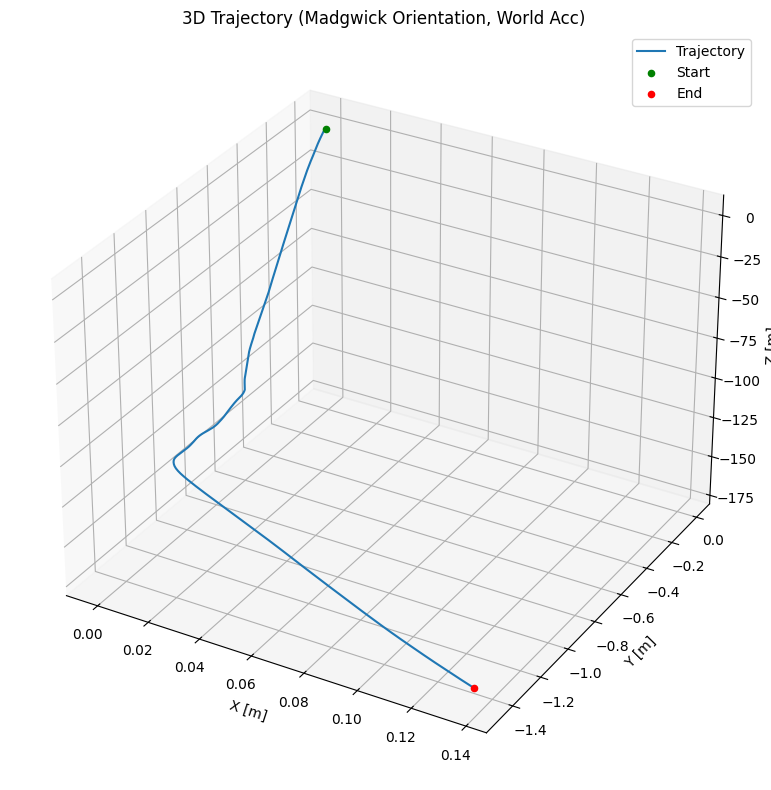

In [46]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
filepath = r'imu_logs\straight_up.csv'
# Load your real data
df = pd.read_csv(filepath)

# Extract needed columns
t = df.index.values*0.01                    # Time in seconds
dt = np.diff(t, prepend=t[0])      # time steps (should be ~constant, but safe)
acc = df[['AccX', 'AccY', 'AccZ']].values
gyro = df[['AsX', 'AsY', 'AsZ']].values * np.pi / 180.0   # Convert gyro to rad/s because Madgwick expects rad/s

# --- Madgwick Filter Setup ---
madgwick = Madgwick(sampleperiod=np.mean(dt), beta=0.1)

# Initialize
quats = np.zeros((len(t), 4))
q = np.array([1.0, 0.0, 0.0, 0.0])

for i in range(len(t)):
    q = madgwick.updateIMU(q, gyr=gyro[i], acc=acc[i])
    quats[i] = q

# --- Rotate Acceleration to World Frame ---
r = R.from_quat(quats)
acc_world = r.apply(acc)

# --- Subtract Gravity (assuming world frame Z is up) ---
gravity = np.array([0, 0, 9.81])
acc_world_no_gravity = acc_world - gravity

# --- Integrate Acceleration to Velocity ---
vel = np.cumsum(acc_world_no_gravity * dt[:, None], axis=0)

# --- Integrate Velocity to Position ---
pos = np.cumsum(vel * dt[:, None], axis=0)

# --- Plot Trajectory ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[:,0], pos[:,1], pos[:,2], label='Trajectory')
ax.scatter(pos[0,0], pos[0,1], pos[0,2], color='green', label='Start')
ax.scatter(pos[-1,0], pos[-1,1], pos[-1,2], color='red', label='End')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('3D Trajectory (Madgwick Orientation, World Acc)')
ax.legend()
plt.tight_layout()
plt.show()


(412, 14)
Index(['timestamp', 'AccX', 'AccY', 'AccZ', 'AngX', 'AngY', 'AngZ', 'AsX',
       'AsY', 'AsZ', 'Q0', 'Q1', 'Q2', 'Q3'],
      dtype='object')


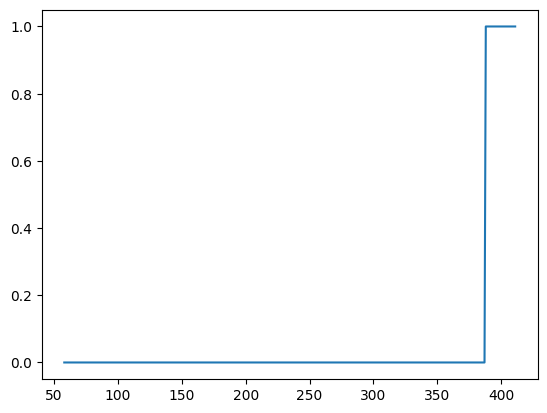

In [47]:

data = pd.read_csv(filepath)
#data.reset_index(inplace=True,drop=True)
#data.index = data.index*10/1000  #10
timestep = 1/100
print(data.shape)
print(data.columns)
data['total_acc_change']= (data[['AccX', 'AccY', 'AccZ']].diff().rolling(10).mean().sum(axis=1).abs())
data['active_period'] = (data['total_acc_change']>0.5).astype(int).rolling(10).min().rolling(50).max()#.shift(-20)
data['active_period'].plot()
#data = data[data['active_period']==1]
df = data

In [48]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

# ————— Extract raw accel and angles —————
acc = df[['AccX', 'AccY', 'AccZ']].values
rpy = df[['AngX', 'AngY', 'AngZ']].values

# ————— Build orientation objects —————
rot = R.from_euler('xyz', rpy, degrees=True)

# ————— Per-sample gravity removal & world-frame accel —————
g_world = np.array([0, 0, 9.81])
n = len(acc)
acc_world = np.zeros((n, 3))

for i in range(n):
    g_body_i     = rot[i].inv().apply(g_world)
    a_dyn_body   = acc[i] - g_body_i
    acc_world[i] = rot[i].apply(a_dyn_body)

# ————— Remove mean residual to zero net accel —————
residual_mean = np.mean(acc_world, axis=0)
acc_world -= residual_mean

# ————— Manual trapezoidal integration at 100 Hz —————
dt = 1.0 / 100.0  # 0.01 seconds
vel = np.zeros_like(acc_world)
pos = np.zeros_like(acc_world)

for i in range(1, n):
    vel[i] = vel[i-1] + 0.5 * (acc_world[i] + acc_world[i-1]) * dt
    pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt

# ————— Plot trajectory —————
fig = go.Figure([
    go.Scatter3d(
        x=pos[:, 0], y=pos[:, 1], z=pos[:, 2],
        mode='lines', line=dict(color='blue', width=4),
        name='Trajectory'
    ),
    go.Scatter3d(
        x=[0], y=[0], z=[0],
        mode='markers', marker=dict(color='green', size=8),
        name='Start'
    ),
    go.Scatter3d(
        x=[pos[-1, 0]], y=[pos[-1, 1]], z=[pos[-1, 2]],
        mode='markers', marker=dict(color='red', size=8),
        name='End'
    )
])
fig.update_layout(
    scene=dict(
        xaxis_title='X [m]',
        yaxis_title='Y [m]',
        zaxis_title='Z [m]',
        aspectmode='data'
    ),
    title='Trajectory with Manual Integration @100Hz',
    margin=dict(l=0, r=0, b=0, t=30)
)
fig.show()
